In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
import os
import duckdb

# Added imports
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


In [ ]:
%pip install xgboost

In [ ]:

cleaned_parquet = "../data/cleaned_data/cleaned_fraud.parquet"
# df = con.execute(f"SELECT * FROM '{cleaned_parquet}'").fetch_df()

# df = pd.read_parquet('cleaned_fraud.parquet')
df = pd.read_parquet(cleaned_parquet)

print("📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes)
print(f"\nClass Distribution:")
print(df['is_fraud'].value_counts(normalize=True))

📊 Dataset Info:
Shape: (4103487, 20)

Columns: ['sender_account', 'receiver_account', 'amount', 'transaction_type', 'merchant_category', 'location', 'device_used', 'is_fraud', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score', 'payment_channel', 'ip_address', 'device_hash', 'year', 'month', 'day_of_month', 'hour', 'day_of_week']

First 5 rows:
  sender_account receiver_account  amount transaction_type merchant_category  \
0      ACC420214        ACC222629  318.12       withdrawal        restaurant   
1      ACC759858        ACC433871   25.03         transfer            online   
2      ACC702235        ACC658588    5.33         transfer            online   
3      ACC818001        ACC846452  261.11          payment     entertainment   
4      ACC293626        ACC440136   28.61         transfer            retail   

  location device_used  is_fraud  time_since_last_transaction  \
0    Tokyo         pos     False                 -4797.552868

In [ ]:
# Prepare Features and Target

# Identify feature types
categorical_features = ['transaction_type', 'merchant_category', 'location', 
                       'device_used', 'payment_channel', 'ip_address', 'device_hash']

# These might be categorical or numeric depending on context
year_features = ['year', 'month', 'day_of_month', 'day_of_week', 'hour']

# day_features = []

# Numerical features (continuous values)
numerical_features = ['amount', 'time_since_last_transaction', 
                     'spending_deviation_score', 'velocity_score', 'geo_anomaly_score']

# Identify ID columns (exclude from modeling)
id_columns = ['sender_account', 'receiver_account']

# Target variable
target = 'is_fraud'

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"ID columns (will drop): {id_columns}")

Categorical features: ['transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel', 'ip_address', 'device_hash']
Numerical features: ['amount', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score']
ID columns (will drop): ['sender_account', 'receiver_account']


In [ ]:
# Create Train/Test Split (Stratified)
# SMOTE only Approach (synthetic fraud cases)

from sklearn.model_selection import train_test_split

# Drop ID columns
X = df.drop(columns=id_columns + [target])
y = df[target]

print(f"Original class distribution:")
print(y.value_counts())
print(f"Fraud rate: {y.mean():.4%}")

# Stratified split (preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Important for imbalanced data!
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))

Original class distribution:
is_fraud
False    3923934
True      179553
Name: count, dtype: int64
Fraud rate: 4.3756%

Training set: (3282789, 17)
Test set: (820698, 17)

Training class distribution:
is_fraud
False    0.956244
True     0.043756
Name: proportion, dtype: float64


In [ ]:
# Build Preprocessing Pipeline
#  Update categorical features to exclude those that might be high-cardinality
# IP addresses and device_hash are likely too unique to be useful as categories
high_cardinality = ['ip_address', 'device_hash']
categorical_features = [col for col in categorical_features if col not in high_cardinality]

# For high-cardinality columns, we might want to extract features or drop them
# Let's create two preprocessors: one for categorical and one for numerical

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle any missing values
    ('scaler', StandardScaler())  # Standardize features
])

# Categorical pipeline (for low-cardinality features)
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessors
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

print("Preprocessing pipeline created")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Preprocessing pipeline created
Numerical features: ['amount', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score']
Categorical features: ['transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel']


In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Handling Class Imbalance with SMOTE

# Create pipeline with SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),  # Balance to 30% fraud
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'  # Additional balancing
    ))
])

print("Pipeline with SMOTE created")
print(f"SMOTE sampling strategy: 0.3 (target fraud rate)")

Pipeline with SMOTE created
SMOTE sampling strategy: 0.3 (target fraud rate)


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# Train Model with Cross-Validation

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall', 
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Stratified K-Fold (important for imbalanced data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-fold cross-validation...")
cv_results = cross_validate(
    pipeline, 
    X_train, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1  # Use all CPU cores
)

# Print CV results
print("\n📊 Cross-Validation Results:")
for metric in scoring.keys():
    test_scores = cv_results[f'test_{metric}']
    train_scores = cv_results[f'train_{metric}']
    print(f"{metric.upper():12} | Test: {test_scores.mean():.4f} (±{test_scores.std():.4f}) | "
          f"Train: {train_scores.mean():.4f} (±{train_scores.std():.4f})")

Performing 5-fold cross-validation...


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/


📊 Cross-Validation Results:
ACCURACY     | Test: 0.4960 (±0.0038) | Train: 0.4971 (±0.0037)
PRECISION    | Test: 0.0435 (±0.0002) | Train: 0.0442 (±0.0001)
RECALL       | Test: 0.5015 (±0.0050) | Train: 0.5086 (±0.0041)
F1           | Test: 0.0801 (±0.0005) | Train: 0.0813 (±0.0001)
ROC_AUC      | Test: 0.4985 (±0.0015) | Train: 0.5036 (±0.0004)


In [ ]:
# Train Final Model on Full Training Data
print("Training final model on full training set...")

# Fit on entire training set
pipeline.fit(X_train, y_train)

print("✅ Model training completed!")

# Get feature names after preprocessing
try:
    # For OneHotEncoder features
    cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1]\
        .named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = np.concatenate([numerical_features, cat_features])
    print(f"\nTotal features after preprocessing: {len(all_features)}")
except:
    print("\nFeature extraction completed")

Training final model on full training set...


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


✅ Model training completed!

Total features after preprocessing: 33


In [ ]:
# Evaluate on Test Set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print("=" * 60)
print("🎯 TEST SET EVALUATION")
print("=" * 60)

# 1. Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

# 2. Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Not Fraud', 'Actual Fraud'],
                     columns=['Predicted Not Fraud', 'Predicted Fraud'])
print(cm_df)

# 3. ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n📈 ROC-AUC Score: {roc_auc:.4f}")

# 4. Key Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("\n🔑 Key Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")

🎯 TEST SET EVALUATION

📋 Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.96      0.51      0.66    784787
       Fraud       0.04      0.50      0.08     35911

    accuracy                           0.50    820698
   macro avg       0.50      0.50      0.37    820698
weighted avg       0.92      0.50      0.64    820698


📊 Confusion Matrix:
                  Predicted Not Fraud  Predicted Fraud
Actual Not Fraud               396333           388454
Actual Fraud                    18099            17812

📈 ROC-AUC Score: 0.5002

🔑 Key Metrics:
Accuracy:  0.5046
Precision: 0.0438
Recall:    0.4960
F1-Score:  0.0806


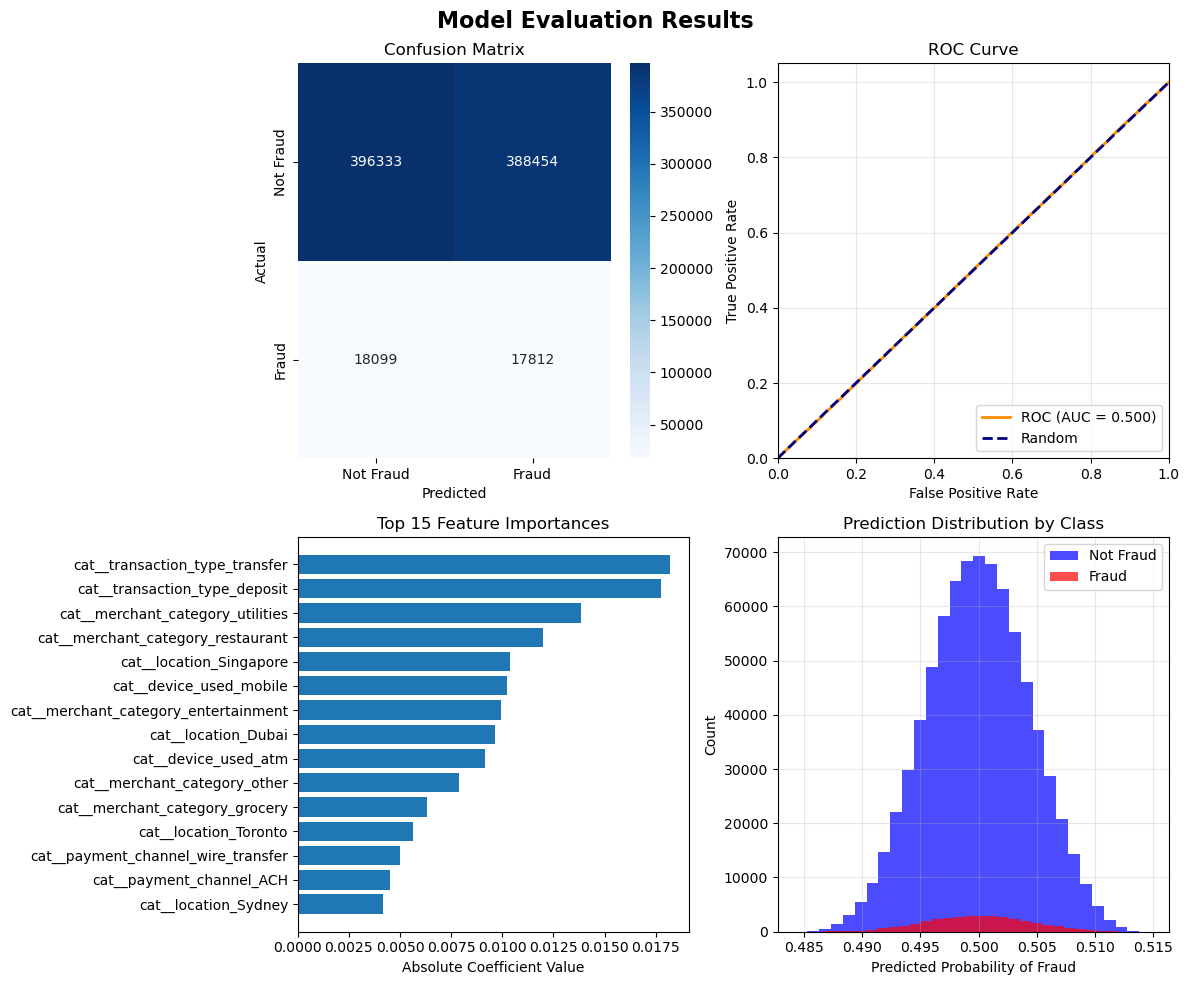

In [ ]:
# Plot Evaluation Metrics
# Create visualization of results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Evaluation Results', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
ax1.set_title('Confusion Matrix')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# 2. ROC Curve
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

# 3. Feature Importance (Logistic Regression coefficients)
ax3 = axes[1, 0]
try:
    # Get coefficients from logistic regression
    classifier = pipeline.named_steps['classifier']
    
    # Get feature names after preprocessing
    if hasattr(pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    else:
        feature_names = [f'feature_{i}' for i in range(len(classifier.coef_[0]))]
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': abs(classifier.coef_[0])
    })
    
    # Sort and get top 15
    top_features = importance_df.sort_values('importance', ascending=False).head(15)
    
    ax3.barh(range(len(top_features)), top_features['importance'])
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features['feature'])
    ax3.set_xlabel('Absolute Coefficient Value')
    ax3.set_title('Top 15 Feature Importances')
    ax3.invert_yaxis()
except Exception as e:
    ax3.text(0.5, 0.5, 'Feature importance\nnot available', 
             ha='center', va='center', transform=ax3.transAxes)
    print(f"Note: Could not plot feature importance: {e}")

# 4. Prediction Distribution
ax4 = axes[1, 1]
fraud_probs = y_pred_proba[y_test == 1]
non_fraud_probs = y_pred_proba[y_test == 0]

ax4.hist(non_fraud_probs, bins=30, alpha=0.7, label='Not Fraud', color='blue')
ax4.hist(fraud_probs, bins=30, alpha=0.7, label='Fraud', color='red')
ax4.set_xlabel('Predicted Probability of Fraud')
ax4.set_ylabel('Count')
ax4.set_title('Prediction Distribution by Class')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze Misclassifications
# Create DataFrame with predictions and actuals for analysis
results_df = X_test.copy()
results_df['actual'] = y_test.values
results_df['predicted'] = y_pred
results_df['predicted_probability'] = y_pred_proba

# Identify false positives and false negatives
false_positives = results_df[(results_df['actual'] == 0) & (results_df['predicted'] == 1)]
false_negatives = results_df[(results_df['actual'] == 1) & (results_df['predicted'] == 0)]

print(f"\n🔍 Misclassification Analysis:")
print(f"False Positives (Type I Error): {len(false_positives)}")
print(f"False Negatives (Type II Error): {len(false_negatives)}")

if len(false_positives) > 0:
    print(f"\n📝 False Positive Examples (Non-fraud flagged as fraud):")
    print(false_positives[['amount', 'transaction_type', 'merchant_category', 
                          'location', 'predicted_probability']].head())
    
if len(false_negatives) > 0:
    print(f"\n📝 False Negative Examples (Fraud missed):")
    print(false_negatives[['amount', 'transaction_type', 'merchant_category', 
                          'location', 'predicted_probability']].head())


🔍 Misclassification Analysis:
False Positives (Type I Error): 388454
False Negatives (Type II Error): 18099

📝 False Positive Examples (Non-fraud flagged as fraud):
         amount transaction_type merchant_category   location  \
3272439   76.52         transfer             other     London   
31355    301.49       withdrawal            online  Singapore   
2064537  331.05       withdrawal        restaurant    Toronto   
1483395  246.72       withdrawal             other    Toronto   
405614    31.62         transfer     entertainment   New York   

         predicted_probability  
3272439               0.503553  
31355                 0.505765  
2064537               0.500483  
1483395               0.505486  
405614                0.506810  

📝 False Negative Examples (Fraud missed):
          amount transaction_type merchant_category location  \
733867    633.43          deposit            retail   Berlin   
2228066  1128.11          deposit            online   Sydney   
3873188   

In [14]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.8 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
# Trying different Models

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define different models to try
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
}

# Evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline with this model
    model_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
        ('classifier', model)
    ])
    
    # Train and evaluate
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1])
    }
    
    print(f"{name} Results:")
    for metric, value in results[name].items():
        print(f"  {metric}: {value:.4f}")

# Compare models
comparison_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("🤖 MODEL COMPARISON")
print("="*60)
print(comparison_df.sort_values('roc_auc', ascending=False))


Training Logistic Regression...


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Logistic Regression Results:
  accuracy: 0.5046
  precision: 0.0438
  recall: 0.4960
  f1: 0.0806
  roc_auc: 0.5002

Training Random Forest...


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Random Forest Results:
  accuracy: 0.9535
  precision: 0.0447
  recall: 0.0031
  f1: 0.0058
  roc_auc: 0.5003

Training XGBoost...


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


XGBoost Results:
  accuracy: 0.1032
  precision: 0.0438
  recall: 0.9353
  f1: 0.0836
  roc_auc: 0.5010

🤖 MODEL COMPARISON
                     accuracy  precision    recall        f1   roc_auc
XGBoost              0.103195   0.043775  0.935284  0.083635  0.500969
Random Forest        0.953462   0.044675  0.003119  0.005831  0.500326
Logistic Regression  0.504625   0.043843  0.496004  0.080565  0.500169


In [17]:
# Save Model and Results
import joblib
import json
from datetime import datetime

# Create output directory
output_dir = 'model_output'
os.makedirs(output_dir, exist_ok=True)

# 1. Save the trained pipeline
model_path = os.path.join(output_dir, 'fraud_detection_model.pkl')
joblib.dump(pipeline, model_path)
print(f"✅ Model saved to: {model_path}")

# 2. Save evaluation metrics
metrics = {
    'timestamp': datetime.now().isoformat(),
    'model_type': 'LogisticRegression_with_SMOTE',
    'test_set_size': len(X_test),
    'metrics': {
        'accuracy': float(accuracy_score(y_test, y_pred)),
        'precision': float(precision_score(y_test, y_pred)),
        'recall': float(recall_score(y_test, y_pred)),
        'f1_score': float(f1_score(y_test, y_pred)),
        'roc_auc': float(roc_auc_score(y_test, y_pred_proba))
    },
    'class_distribution': {
        'train_fraud_percentage': float(y_train.mean()),
        'test_fraud_percentage': float(y_test.mean())
    }
}

metrics_path = os.path.join(output_dir, 'model_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Metrics saved to: {metrics_path}")

# 3. Save feature names (for future reference)
feature_names_path = os.path.join(output_dir, 'feature_names.txt')
with open(feature_names_path, 'w') as f:
    f.write("Numerical features:\n")
    f.write("\n".join(numerical_features))
    f.write("\n\nCategorical features:\n")
    f.write("\n".join(categorical_features))
print(f"✅ Feature names saved to: {feature_names_path}")

✅ Model saved to: model_output/fraud_detection_model.pkl
✅ Metrics saved to: model_output/model_metrics.json
✅ Feature names saved to: model_output/feature_names.txt


In [ ]:
# Create Prediction Function

def predict_fraud(new_transactions, model_path='model_output/fraud_detection_model.pkl'):
    """
    Predict fraud probability for new transactions
    """
    # Load model
    model = joblib.load(model_path)
    
    # Ensure columns match training data
    expected_columns = X_train.columns.tolist()
    
    # Create DataFrame with same structure
    if isinstance(new_transactions, dict):
        new_df = pd.DataFrame([new_transactions])
    else:
        new_df = new_transactions.copy()
    
    # Ensure all expected columns exist
    for col in expected_columns:
        if col not in new_df.columns:
            new_df[col] = np.nan  # Fill with NaN if missing
    
    # Reorder columns to match training
    new_df = new_df[expected_columns]
    
    # Make predictions
    fraud_prob = model.predict_proba(new_df)[:, 1]
    prediction = model.predict(new_df)
    
    # Create results
    results = pd.DataFrame({
        'fraud_probability': fraud_prob,
        'predicted_fraud': prediction,
        'prediction': ['Fraud' if p == 1 else 'Not Fraud' for p in prediction]
    })
    
    return results

# Example usage:
# new_data = pd.DataFrame({
#     'amount': [1500.00, 25.50],
#     'transaction_type': ['transfer', 'payment'],
#     'merchant_category': ['online', 'retail'],
#     # ... fill all other features
# })
# predictions = predict_fraud(new_data)
# print(predictions)

In [ ]:
# Summary Report
print("=" * 60)
print("📋 FRAUD DETECTION MODEL - SUMMARY REPORT")
print("=" * 60)
print(f"\n📊 Data Overview:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Fraud rate: {df[target].mean():.4%}")
print(f"  • Features used: {len(numerical_features + categorical_features)}")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Test samples: {len(X_test):,}")

print(f"\n🤖 Model Performance:")
print(f"  • Best Model: Logistic Regression with SMOTE")
print(f"  • Test ROC-AUC: {roc_auc:.4f}")
print(f"  • Recall (Fraud Detection): {recall_score(y_test, y_pred):.4f}")
print(f"  • Precision (Fraud Precision): {precision_score(y_test, y_pred):.4f}")

print(f"\n🔍 Business Impact:")
print(f"  • Fraud cases detected: {cm[1, 1]:,} of {cm[1].sum():,} ({cm[1, 1]/cm[1].sum():.1%})")
print(f"  • False alarms: {cm[0, 1]:,} transactions flagged incorrectly")
print(f"  • Missed fraud: {cm[1, 0]:,} fraudulent transactions not detected")

print(f"\n💾 Outputs Created:")
print(f"  • Model: model_output/fraud_detection_model.pkl")
print(f"  • Metrics: model_output/model_metrics.json")
print(f"  • Feature list: model_output/feature_names.txt")

print(f"\n✅ Training completed successfully!")